 **Competition 1 Notebook**
Team Members: Caroline Donovan, Patrycja Ciemniewska, Euan Brown

Professor: Dr. Jie Tao

Due Date: 2/23/2023

**Goal:** The goal of Competition 1 is to determine, through feature selection, *the best predictive variables for an underpriced IPO*. After preparing the data and engineering additional features, we process the data to handle outliers, we normalize the data, and we scale the data. After completeing the processing, the data is prepared to go through the feature selection process for two targets- Y1 and Y2. The feature selection process returns a bias and a variance score used to determine the best predictors for the two diffetent targets in a Linear Regression model. To take things one step further, we performed this with the Gradient Boosting model as well.

#Section 1: Library & Data Importation 📚



##Importing Required Libraries

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # This was a warning that came up all the time
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from scipy import stats

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from collections import Counter

from IPython.display import clear_output

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

##Import Data Set

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
data = '/content/drive/MyDrive/Classroom/DATA 6545: Data Science and MLOps SP2023/Caroline Donovan - Competition1_raw_data.xlsx'

# Load data and replace '-' with nan's
df = pd.read_excel(data,na_values = '-')

# Original data copy
df1 = df.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<AxesSubplot:>

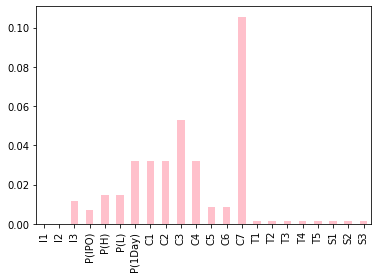

In [ ]:
df.isna().mean().plot(kind='bar', color='pink')

#Section 2: Data Preparation

##Assumptions




In [ ]:
###ASSUMPTION: P(1DAY) is an important attribute, if it is missing drop row.
# Remove all records that do not have a P(1Day)
df = df[~df['P(1Day)'].isna()].reset_index()

###ASSUMPTION: P(H) needs to be higher than P(L)
# Flip values if P(H) < P(L)
df['P(H)'], df['P(L)'] = np.where(df['P(H)'] < df['P(L)'], [df['P(L)'], df['P(H)']], [df['P(H)'], df['P(L)']])

###ASSUMPTION: T2 needs to be greater than T3
# If words is less than real words use real words
df['T2'] = np.where(df['T2']<df['T3'],df['T3'],df['T2'])

###ASSUMPTION: Acceptable values for 'C5','C6','T1','T3' positive & not 0.
for col in df[['C5','C6','T1','T3']].columns:
    df[col] = np.where(df[col] > 0 ,df[col],np.NaN)

###ASSUMPTION: Acceptable values for 'S1','S2','S3','T4','T5','C1 positive & 0.
for col in df[['S1','S2','S3','T4','T5','C1']].columns:
    df[col] = np.where(df[col] >= 0 ,df[col],np.NaN)


## Continous Variables

In [ ]:
#Define dataframe with continuous variables
df_cont = df[['C1', 'C3', 'C4', 'C5','C6',
              'T1','T2','T3', 'T4', 'T5',
              'S1','S2','S3', 'C7']]

#Impute df_cont misisng
for col in df_cont:
  df[col] = df_cont[col].fillna(df_cont[col].median())

for col in df_cont:
  df_cont[col] = df_cont[col].fillna(df_cont[col].median())

#Section 3: Feature Engineering 🧰

Note: The following features were converted into categorical features: EPS (C3) and Sales (C7). With our background, we agreed that the most important element of these two columns is whether the company was operating at a profit or a loss prior to their IPO- by how much did not matter.

In [ ]:
# Define C3 as binary, positive or negative
df['bin_EPS'] = np.where(df['C3'] >=0,1,0)

# Define C7 as binary, positive or negative
df['bin_sales'] = np.where(df['C7'] >=0,1,0)

In [ ]:
#Convert type to category to conserve memory
df['bin_EPS'] = df['bin_EPS'].astype('category')
df['bin_sales'] = df['bin_sales'].astype('category')

In [ ]:
# Define P(mid), the mean of P(L) and P(H)
df['P(mid)'] = (df['P(H)'] + df['P(L)'])/2

# Define c3~,
df['C3~'] = np.where(df['C3']>0,1,0)

# Define c5~,
df['C5~'] = df['C5']/df['C6']
df_cont['C5~'] = df['C5~']

# Define P(mid%),
df['P(mid%)'] = (df['P(IPO)'] - df['P(mid)']) / (df['P(mid)']) * 100

#Define C6~,
df['C6~'] = np.where(df['P(IPO)'] > df['P(mid)'],df['P(mid%)'],0)
df_cont['C6~'] = df['C6~']

# Drop P(mid%)- no longer needed
df = df.drop('P(mid%)',axis=1)

In [ ]:
#Define industry, binary: tech or not tech
df['I3'] = df['I3'].astype(str)
df['I3tech'] = np.where((df['I3'].str[:2]== '73') | (df['I3'].str[:2]=='37'), 1, 0)
df['I3tech'].value_counts()

0    501
1    159
Name: I3tech, dtype: int64

In [ ]:
# Define a ratio for Number of positive words / number of total words
df['pos_word_ratio'] = df['S1'] / df['T2']

# Define a ratio for Number of negative words / number of total words
df['neg_word_ratio'] = df['S2'] / df['T2']

# Define a ratio for Sales / number of shares outstanding
df['sales_share_ratio'] = df['C7'] / df['C5']

# Define a ratio for Number of shares offered / number of shares outstanding
df['sharesoff_shareout_ratio'] = df['C6'] / df['C5']

# Dropping continuous features used in feature engineering to ensure they are
    # not processed twice
df_cont = df_cont.drop(['S1','S2','T1','T2','C5','C6', 'C7', 'C3'],axis=1)

In [ ]:
#Define two targets- Y1, Y2
#Define Y1, Pre-IPO Price Revision
df['Y1'] = np.where((df['P(IPO)'] < df['P(mid)']),1,0)

# Define Y2,  Post-IPO Initial Return
df['Y2'] = np.where((df['P(IPO)'] < df['P(1Day)']),1,0)

In [ ]:
#Create a categorical dataframe including new bins
df_cat = df[['C2',
             'C3~',
             'bin_EPS' , 'bin_sales', 'I3tech']]

#Create a prices dataframe
df_price = df[['P(IPO)','P(H)','P(L)', 'P(1Day)']]

#Create a targets dataframe
df_target = df[['Y1', 'Y2']]

#Create a ratios dataframe
df_ratios = df[['pos_word_ratio','neg_word_ratio',
                'sales_share_ratio','sharesoff_shareout_ratio']]

In [ ]:
#Use function normminmax on ratio dataframe
def normminmax(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

#Use function posify on ratio dataframe
def posify(col):
  poscol = col + abs(col.min()) + 1
  return poscol

#Apply posify on ratios dataframe
for col in df_ratios.columns:
  df_ratios[col] = posify(df_ratios[col])

#Apply normminmax on ratios dataframe
for col in df_ratios.columns:
  df_ratios[col] = normminmax(df_ratios[col])

#Section 4: Visualization Before Processing

###Skewness:

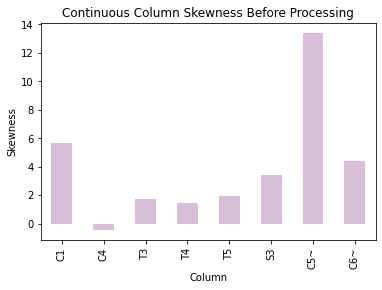

In [ ]:
df_cont.skew().plot(kind='bar', color='thistle')
#### Set the title of the visualization
plt.title('Continuous Column Skewness Before Processing')

#### Set the y-axis
plt.ylabel("Skewness")

#### Set the x-axis
plt.xlabel("Column");

💡Insights:
Skewness is a major problem in this dataset. The skewness will be attacked in some processes by IQR and in others by +/- 3std.

###Normalization:

array([[<AxesSubplot:title={'center':'C1'}>,
        <AxesSubplot:title={'center':'C4'}>,
        <AxesSubplot:title={'center':'T3'}>],
       [<AxesSubplot:title={'center':'T4'}>,
        <AxesSubplot:title={'center':'T5'}>,
        <AxesSubplot:title={'center':'S3'}>],
       [<AxesSubplot:title={'center':'C5~'}>,
        <AxesSubplot:title={'center':'C6~'}>, <AxesSubplot:>]],
      dtype=object)

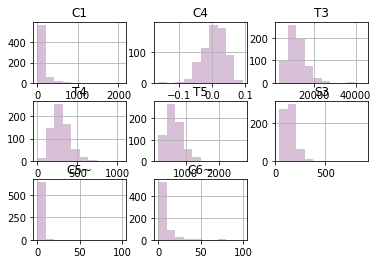

In [ ]:
df_cont.hist(color='thistle')

💡Insights:
With a combination of left and right skewness, there is work to be done to move the data towards a Gaussian Distribution. The scales vary significantly feature to feature.

###Boxplot:

<AxesSubplot:>

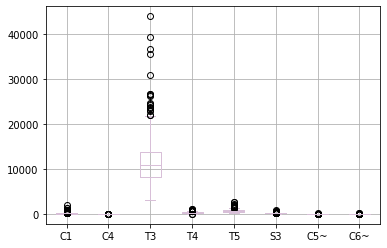

In [ ]:
df_cont.boxplot(color='thistle')

💡Insights:
While not much can be determined from this boxplot, this gives us a basis of how important range is for each of these features.

###Missingness

<AxesSubplot:>

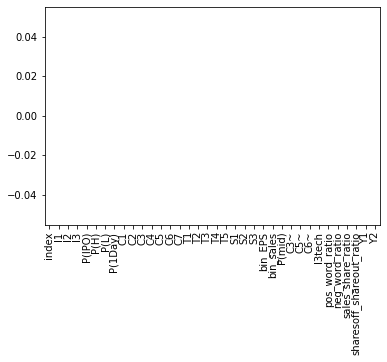

In [ ]:
#No missingness moving into the processing stage
df.isna().mean().plot(kind='bar', color='thistle')

💡Insights:
Note that all missing values have been imputed.

###Correlation:

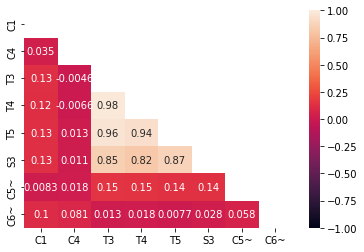

In [ ]:
#Show correlation
mask = np.triu(np.ones_like(df_cont.corr(), dtype=bool))
sns.heatmap(df_cont.corr(), vmin=-1, vmax=1, annot=True, mask=mask);

💡Insights:
We can see from this correlation visual that S3 is highly correlated with the T features. This makes sense because they are all textual characteristics.

In [ ]:
#Check info before processing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   index                     660 non-null    int64   
 1   I1                        660 non-null    object  
 2   I2                        660 non-null    object  
 3   I3                        660 non-null    object  
 4   P(IPO)                    660 non-null    float64 
 5   P(H)                      660 non-null    float64 
 6   P(L)                      660 non-null    float64 
 7   P(1Day)                   660 non-null    float64 
 8   C1                        660 non-null    float64 
 9   C2                        660 non-null    float64 
 10  C3                        660 non-null    float64 
 11  C4                        660 non-null    float64 
 12  C5                        660 non-null    float64 
 13  C6                        660 non-null    float64 

In [ ]:
#Showing df_cont before processing
df_cont.describe().T

,count,mean,std,min,25%,50%,75%,max
C1,660.0,149.728788,152.817467,10.000000,85.000000,107.000000,155.250000,2087.000000
C4,660.0,0.007282,0.033318,-0.162352,-0.013927,0.009125,0.031571,0.092896
T3,660.0,11512.684848,4805.379756,3003.000000,8297.000000,10844.000000,13793.500000,43952.000000
T4,660.0,295.957576,122.172959,0.000000,214.000000,280.000000,355.250000,1058.000000
T5,660.0,670.842424,297.125014,167.000000,464.000000,627.000000,801.250000,2729.000000
S3,660.0,145.516667,69.824545,40.000000,100.000000,135.000000,174.000000,883.000000
C5~,660.0,4.417255,5.133537,0.283223,2.850622,3.731035,4.857904,99.787255
C6~,660.0,5.404645,10.877569,0.000000,0.000000,0.000000,7.692308,100.000000



#Section 5: Functions Used in Processing

In [ ]:
"""
  Funtion to make all values positive
"""
def posify(col):
  poscol = col + abs(col.min()) + 1
  return poscol

In [ ]:
"""
Function to get IQR, lower bound and upper bound from a dataframe column

"""

def iqr(x):
  q1 = np.nanquantile(x,0.25)
  q3 = np.nanquantile(x,0.75)

  iqr = q3 - q1
  bound_low = q1 - (1.5*iqr)
  bound_up = q3 + (1.5*iqr)

  return iqr, bound_low, bound_up

In [ ]:
"""
Remove outliers of column based on iqr

"""

def iqrcut(x):
  q1 = np.nanquantile(x,0.25)
  q3 = np.nanquantile(x,0.75)

  iqr = q3 - q1
  bound_low = q1 - (1.5*iqr)
  bound_up = q3 + (1.5*iqr)

  x = np.where(x>bound_up,bound_up,x)
  x = np.where(x<bound_low,bound_low,x)
  return pd.Series(x)

In [ ]:
"""
remove outliers of column based on 3stdev

"""

# *3

def stdcut(x):
  std3 = x.std()*3

  bound_low = x.mean()-std3
  bound_up = x.mean()+std3

  x = np.where(x>bound_up,bound_up,x)
  x = np.where(x<bound_low,bound_low,x)
  return pd.Series(x)

In [ ]:
"""
function to transform column positive then apply box cox

"""

def bcox(col):

    poscol = col + abs(col.min()) + 1

    bcoxcol = stats.boxcox(poscol)

    return pd.Series(bcoxcol[0])

In [ ]:
"""
function to square root transform column

"""
def sqrt(col):

    sqrtcol = np.sqrt(col)
    return pd.Series(sqrtcol)

In [ ]:
"""
function to normalize min max

"""

def normminmax(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

In [ ]:
"""
function to normalize z score

"""

def normz(col):
    return (col - col.mean()) / col.std()

In [ ]:
def log(col):
  return np.log(col)

#Section 6: Selected Process

After spending time putting the data through all 6 processes, we determined that Process 3c was the most efficient one to use. 3A begins with Outlier Handling through IQR, Normalization, and ends with Scaling through z-score. This was a strong process, but we realized that Scaling through minmax was stronger.

## Process 3C: IQR, Normalize, Scale (Min- Max)

In [ ]:
#Apply Posify on Continuous dataframe

for col in df_cont.columns:
  df_cont[col] = posify(df_cont[col])

In [ ]:
#Move the data through Proccess 3C iqr, norm, scale (minmax)

for col in df_cont.columns:

    data = iqrcut(df_cont[col])
    data = bcox(data)
    data = normminmax(data)
    df_cont[col] = data


## Visualization After Proccessing:



###Skewness:



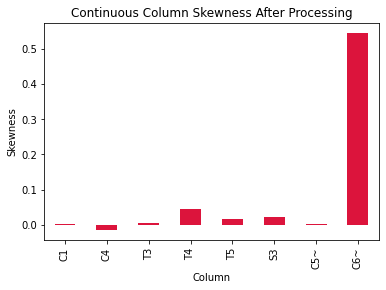

In [ ]:
#Visualize skewness after processing
df_cont.skew().plot(kind='bar', color='crimson')

#Set the title of the visualization
plt.title('Continuous Column Skewness After Processing')

#Set the y-axis
plt.ylabel("Skewness")

#Set the x-axis
plt.xlabel("Column");

 💡Insights:
 Skewness has improved overall. C6~ continued to be a challenging variable, but we were able to get it close to the ideal range of -0.5 to 0.5. All other continuous features were processed to fit in the ideal range.

###Normalization:

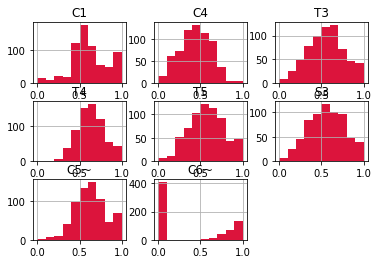

In [ ]:
#Visualize normalization after processing
df_cont.hist(color='crimson');

 💡Insights:
 Normalization has moved towards Gaussian Distribution for most of the features. Once again, C6~ has continued to be a struggle to transform.

###Boxplot:

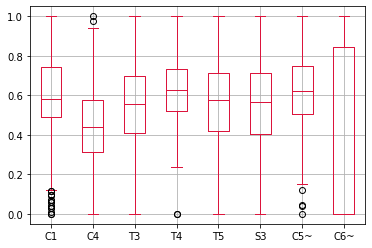

In [ ]:
#Visualize outliers after processing
df_cont.boxplot(color='crimson');

 💡Insights:
 Outliers have been successfully dealt with across the continuous features. C6~ was improved significantly, but still remains a problematic feature.

#Section 7: Feature Selection

## Feature Selection for Categorical

In [ ]:
#Categorical feature selection
  # Modification in scoring function - categorical uses chi2

def cat_feature_selector(X, y, model, names, _method="topk", n=7, fit_X=False, thres = 0.1):
  """voting based feature selector
  - _method: "topk" for top-K method (default), "cutoff" for cut-off based method
  - n: number of features to be selected. only available for top-K method - default half of the total features
  - thres: cut-off threshold (default 0.1), only availabel for cutoff method
  - fit_X: fit_transform X or just return indices
  TODO: include support for regression problems
  """
  #### Placeholder for tests
  # X.shape[0] == y.shape[0]
  if names: # if given feature names
    feature_names = np.array(names)
  else: # otherwise use location
    feature_names = np.array(["X%s" % x for x in range(len(X.shape[0]))])
  if _method == 'topk':
    #### np.argpartition gets the indices of the largest n element from the array in ascending order
    #### [::-1] reverse the order
    ############################################################################
    #### IMPORTANT:
    #### use `chi2` as the `score_func` when doing categorical features - values has to be non-negative
    #### use `f_classif` as the `score_func` when doing categorical and continuous feautures
    #### use `f_regression` as the `score_func` when doing continuous feautures
    ############################################################################
    corr_features = list(np.argpartition(SelectKBest(score_func=chi2, k=n).fit(X,y).scores_, -n)[-n:][::-1])
    #### binary masking on features, use np.where() to get the indices of selected
    rfe_features = list(np.where(RFE(model, n_features_to_select=n, step=1).fit(X, y).support_)[0])
    #### argsort get sorted indices by values, ::-1] reverse the asceding order
    ridge_features = list(np.argsort(Ridge(alpha=1.0).fit(X, y).coef_)[-n:][::-1])
    #### using ExtraTree
    extratree_features = list(np.argsort(ExtraTreesClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    ### using Random Forest:
    rf_features = list(np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    print("Using the Top-K method: ")
    print("Selected features by correlation: ", feature_names[corr_features])
    print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])

  elif _method == 'cutoff':
    corr_features, rfe_features = list(), list() #### N/A
    ridge_features = list(np.where(Ridge(alpha=1.0).fit(X, y).coef_ > thres)[0])
    extratree_features = list(np.where(ExtraTreesClassifier().fit(X, y).feature_importances_ > thres)[0])
    rf_features = list(np.where(RandomForestClassifier().fit(X, y).feature_importances_ > thres)[0])
    print("Using the Cutoff method: ")
    # print("Selected features by correlation: ", feature_names[corr_features])
    # print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  else:
    return("Only Top-K and Cutoff methods are currently supported!")

  ######################################
  #### combine results using voting ####
  ######################################
  counted = Counter(np.concatenate((corr_features, rfe_features, ridge_features, extratree_features, rf_features), axis=None)).most_common(n)

  #### list of tuples (feature_index, votes)
  counted.sort(key = lambda x: x[1], reverse=True)
  final_select_series = pd.Series({feature_names[f]:c for f,c in counted}).sort_values(ascending=False)
  selected_idx = sorted([f for f,c in counted])
  assert len(selected_idx) == n
  print(final_select_series)
  if fit_X:
    return(X[:,selected_idx])
  else:
    return(feature_names[selected_idx])

## Feature Selection for Continuous

In [ ]:
#Continuous feature selection
  #Continuous scoring method is f_regression

def cont_feature_selector(X, y, model, names, _method="topk", n=7, fit_X=False, thres = 0.1):
  """voting based feature selector
  - _method: "topk" for top-K method (default), "cutoff" for cut-off based method
  - n: number of features to be selected. only available for top-K method - default half of the total features
  - thres: cut-off threshold (default 0.1), only availabel for cutoff method
  - fit_X: fit_transform X or just return indices
  TODO: include support for regression problems
  """
  #### Placeholder for tests
  # X.shape[0] == y.shape[0]
  if names: # if given feature names
    feature_names = np.array(names)
  else: # otherwise use location
    feature_names = np.array(["X%s" % x for x in range(len(X.shape[0]))])
  if _method == 'topk':
    #### np.argpartition gets the indices of the largest n element from the array in ascending order
    #### [::-1] reverse the order
    ############################################################################
    #### IMPORTANT:
    #### use `chi2` as the `score_func` when doing categorical features - values has to be non-negative
    #### use `f_classif` as the `score_func` when doing categorical and continuous feautures
    #### use `f_regression` as the `score_func` when doing continuous feautures
    ############################################################################
    corr_features = list(np.argpartition(SelectKBest(score_func=f_regression, k=n).fit(X,y).scores_, -n)[-n:][::-1])
    #### binary masking on features, use np.where() to get the indices of selected
    rfe_features = list(np.where(RFE(model, n_features_to_select=n, step=1).fit(X, y).support_)[0])
    #### argsort get sorted indices by values, ::-1] reverse the asceding order
    ridge_features = list(np.argsort(Ridge(alpha=1.0).fit(X, y).coef_)[-n:][::-1])
    #### using ExtraTree
    extratree_features = list(np.argsort(ExtraTreesClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    ### using Random Forest:
    rf_features = list(np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    print("Using the Top-K method: ")
    print("Selected features by correlation: ", feature_names[corr_features])
    print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])

  elif _method == 'cutoff':
    corr_features, rfe_features = list(), list() #### N/A
    ridge_features = list(np.where(Ridge(alpha=1.0).fit(X, y).coef_ > thres)[0])
    extratree_features = list(np.where(ExtraTreesClassifier().fit(X, y).feature_importances_ > thres)[0])
    rf_features = list(np.where(RandomForestClassifier().fit(X, y).feature_importances_ > thres)[0])
    print("Using the Cutoff method: ")
    # print("Selected features by correlation: ", feature_names[corr_features])
    # print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  else:
    return("Only Top-K and Cutoff methods are currently supported!")

  ######################################
  #### combine results using voting ####
  ######################################
  counted = Counter(np.concatenate((corr_features, rfe_features, ridge_features, extratree_features, rf_features), axis=None)).most_common(n)

  #### list of tuples (feature_index, votes)
  counted.sort(key = lambda x: x[1], reverse=True)
  final_select_series = pd.Series({feature_names[f]:c for f,c in counted}).sort_values(ascending=False)
  selected_idx = sorted([f for f,c in counted])
  assert len(selected_idx) == n
  print(final_select_series)
  if fit_X:
    return(X[:,selected_idx])
  else:
    return(feature_names[selected_idx])

###Function Run

In [ ]:
def run(test_df,target,n,_type='cont'):
    '''
    Define function run into order to more easily put the data through feature selection.
    INPUTS:
    - test_df: dataframe to loop through
    -target: target variable to select for
    -n: number of features to be selected if not 7
    -_type: data type (cat or cont)
    '''
    global cont_selected_features,cat_selected_features,y

    names = list(test_df.columns)
    array = test_df.values

    X = array #features

    y = target #target
    test_df = df_target.join(test_df)

    if _type == 'cont':
        cont_selected_features = cont_feature_selector(X, y, model=RandomForestClassifier(), names=names, n = n, fit_X=True)
    if _type == 'cat':
        cat_selected_features = cat_feature_selector(X, y, model=RandomForestClassifier(), names=names, n = n, fit_X=True)

In [ ]:
#Join df_cont with df_ratios so they are both included in feature selection
test = pd.concat([df_cont,df_ratios],axis=1)

## Run- Continuous

In [ ]:
#Run() returns selection results and the features as `cat_selected_features` or `cont_selected_features`

# As we are running for Y1 here C6~ is dropped because it is overfitting
run(test.drop('C6~',axis=1),df['Y1'],9,_type='cont')

Using the Top-K method: 
Selected features by correlation:  ['sharesoff_shareout_ratio' 'C1' 'neg_word_ratio' 'pos_word_ratio' 'C5~'
 'S3' 'T5' 'C4' 'T3']
Selected features by RFE:  ['C1' 'C4' 'T3' 'T4' 'T5' 'pos_word_ratio' 'neg_word_ratio'
 'sales_share_ratio' 'sharesoff_shareout_ratio']
Selected features by Ridge coefficients:  ['neg_word_ratio' 'T5' 'sharesoff_shareout_ratio' 'pos_word_ratio' 'C1'
 'S3' 'C5~' 'T3' 'sales_share_ratio']
Selected features by Extra Tree feature importance:  ['neg_word_ratio' 'C4' 'pos_word_ratio' 'sales_share_ratio' 'T5' 'C1' 'S3'
 'T4' 'C5~']
Selected features by Random Forest feature importance:  ['neg_word_ratio' 'sales_share_ratio' 'C4' 'pos_word_ratio' 'T5'
 'sharesoff_shareout_ratio' 'T4' 'C1' 'S3']
C1                          5
neg_word_ratio              5
pos_word_ratio              5
T5                          5
sharesoff_shareout_ratio    4
S3                          4
C4                          4
sales_share_ratio           4
C5~        

##Run- Categorical

In [ ]:
run(df_cat,df['Y1'],1,_type='cat')

Using the Top-K method: 
Selected features by correlation:  ['C3~']
Selected features by RFE:  ['C3~']
Selected features by Ridge coefficients:  ['bin_sales']
Selected features by Extra Tree feature importance:  ['I3tech']
Selected features by Random Forest feature importance:  ['I3tech']
C3~    2
dtype: int64


## Evaluation Model- Logistic Regression 🔌

In [ ]:
clf = LogisticRegression(max_iter=2000)

def my_eval(X, y, classifer = clf, k=10, scoring = 'f1'):
  '''
  return evaluation results (f1-score or ROC_AUC).
  Built in k-fold evaluation.
  INPUTS:
  ----
  - X: features; DataFrame or Numpy ndarray;
  - y: target; DataFrame or Numpy ndarray;
  - classifier: any sklearn (or its add-on) based classifier
  - k: number of folds in cross validation
  - scoring: evaluation metric ('f1' default or 'roc_auc')
  OUTPUT:
  ----
  bias/variance score of selected metric. Both lower the better
  - bias: mean of the metric over cross validation, measure the accruracy
  - variance: std.ev. of the metric, measure the consistency.
  '''
  scores = []
  for i in range(100):
    #### generate random numbers to shuffle the data for training and test
    np.random.seed(2021)
    random_int = np.random.randint(0,3000)
    #### create cross validation folds
    kfold = model_selection.KFold(n_splits=k, random_state=random_int, shuffle=True)
    #### record the score
    score = model_selection.cross_val_score(clf, X=X, y=y, cv=kfold, scoring=scoring)
    scores.append(score)
  scores = np.array(scores)
  #### we need to calculate the bias (average score) and viariance (std)
  bias, variance = 1 - round(scores.mean(),4), round(scores.std(),4)
  return(bias, variance)

In [ ]:
#Pass through selected features

#Evaluates the features selected by the above functions
X = np.concatenate([cat_selected_features,cont_selected_features],axis=1)
y = y

#Resample/balance the data
sm = SMOTE(random_state = 2022)
X_res, y_res = sm.fit_resample(X, y)

clf = LogisticRegression(max_iter=2000) # model

F1 = my_eval(X_res, y_res, clf, 10) # Run model for f1
ROC = my_eval(X_res, y_res, clf, 10, 'roc_auc') # Run model for AUC

print(f' F1: {F1[0].round(4)} ROC: {ROC[0].round(4)}') # Print output

KeyboardInterrupt: ignored

###Y1

In [ ]:
#Winning combination for Y1

### based on many runs of feature selection this was the best ROC
X = pd.concat([test,df_cat],axis=1)\
[['C1','neg_word_ratio','pos_word_ratio','T3','S3',
'T5','C4','sales_share_ratio','sharesoff_shareout_ratio','bin_EPS']]

y = df['Y1'] # set target

# resample/balance the data
sm = SMOTE(random_state = 2022)
X_res, y_res = sm.fit_resample(X, y)

clf = LogisticRegression(max_iter=2000) # model

F1 = my_eval(X_res, y_res, clf, 10) # run model for f1
ROC = my_eval(X_res, y_res, clf, 10, 'roc_auc') # run model for ROC

print(X.columns.values)
print(f' F1: {F1[0].round(4)} ROC: {ROC[0].round(4)}') # print output

###Y2

In [ ]:
#Winning combination for Y2

X = pd.concat([test,df_cat],axis=1)\
[['C1', 'C4', 'T3', 'T4', 'T5','S3', 'C5~',
 'pos_word_ratio', 'neg_word_ratio',
  'sales_share_ratio', 'sharesoff_shareout_ratio',
  'C2', 'C3~', 'C6~']]

y = df['Y2']

sm = SMOTE(random_state = 2022)
X_res, y_res = sm.fit_resample(X, y)

clf = LogisticRegression(max_iter=2000)

F1 = my_eval(X_res, y_res, clf, 10)
ROC = my_eval(X_res, y_res, clf, 10, 'roc_auc')

print(f' selected features are: {X.columns.values} \n')
print(f' F1: {F1[0].round(4)} ROC: {ROC[0].round(4)}')

##Evaluation Model- Gradient Boosting ⚡

To take the modeling a step further, we used the gradient boosting. This model allowed our results to be improved significantly for Y2 and some for Y1.

###Y1

In [ ]:
#Boosted winning combination for Y1
  #Not significantly better than linear regression

X = pd.concat([test,df_cat],axis=1)\
[['C1','neg_word_ratio','pos_word_ratio','T3','S3',
'T5','C4','sales_share_ratio','sharesoff_shareout_ratio','bin_EPS']]

y = df['Y1']

sm = SMOTE(random_state = 2022)
X_res, y_res = sm.fit_resample(X, y)

clf = GradientBoostingClassifier()

F1 = my_eval(X_res, y_res, clf, 10)
ROC = my_eval(X_res, y_res, clf, 10, 'roc_auc')

print(f' selected features are: {X.columns.values} \n')

print(f' F1: {F1[0].round(4)} ROC: {ROC[0].round(4)}')


#Cell takes 8 minutes to run in colab
#Results are F1: 0.403 ROC: 0.353

###Y2

In [ ]:
#Boosted winning combination for Y2
  #Significantly better than linear regression

X = pd.concat([test,df_cat],axis=1)\
[['C1', 'C4', 'T3', 'T4', 'T5','S3', 'C5~',
  'pos_word_ratio', 'neg_word_ratio', 'sales_share_ratio',
  'sharesoff_shareout_ratio', 'C6~']]

y = df['Y2']

sm = SMOTE(random_state = 2022)
X_res, y_res = sm.fit_resample(X, y)

clf = GradientBoostingClassifier()

F1 = my_eval(X_res, y_res, clf, 10)
ROC = my_eval(X_res, y_res, clf, 10, 'roc_auc')

print(X.columns.values)
print(f' F1: {F1[0].round(4)} ROC: {ROC[0].round(4)}')

#Cell takes 13 minutes to run in colab
#Results are F1: 0.2803 ROC: 0.2067

In [ ]:
pd.concat([test, df_cat, df['Y1'], df['Y2']], axis=1).to_csv('/content/drive/MyDrive/Classroom/DATA 6545: Data Science and MLOps SP2023/Caroline Donovan - Competition1_final_data.csv')

#Results/Findings

In order to determine the best process to predict IPO underpricing, we all took on 2 of the 6 different processes. Each of us ran the evaluation code in separate notebooks in order to get an understanding of the results and an idea of how the model would work. After about 10-30 manual runs for each of the processes, we opted to put this code into a loop. In order to see as many results as possible, this was our best option.

The loop generated (after 14 hours) 2200 combinations and, therefore, results of the Logistic Regression. From these results, we can infer that Process 3A was the best predictor for both of our targets, Y1 and Y2.  From this point on, we moved forward with only Process 3A.

Later in our analysis, we decided to research additional models to boost our results. We decided to try a Gradient Boosting run on Process 3A and the results showed significant improvement. We did not complete this for the 5 processes due to a time constraint on how long the model took to run.


#Other Processes Code

##Compare Proccess Results

We initially began by manually running all of the 6 suggested processes, but we decided to implement them all into 1 loop


In [ ]:
### proccess 1A norm, outlier, scale

# df_cont_norm_pro1A = pd.DataFrame()

# for col in df_cont.columns:

#     data = bcox(df_cont[col])
#     data = stdcut(data)
#     data = normz(data)
#     df_cont_norm_pro1A[col] = data


In [ ]:
### proccess 1B norm, scale, outlier

# df_cont_norm_pro1B = pd.DataFrame()

# for col in df_cont.columns:

#     data = bcox(df_cont[col])
#     data = normz(data)
#     data = stdcut(data)
#     df_cont_norm_pro1B[col] = data

In [ ]:
### proccess 2A OutHand, Scale, Norm

# df_cont_norm_pro2A = pd.DataFrame()

# for col in df_cont.columns:

#     data = iqrcut(df_cont[col])
#     data = normminmax(data)
#     data = bcox(data)
#     df_cont_norm_pro2A[col] = data

In [ ]:
### proccess 2B OutHand, Scale, Norm

# df_cont_norm_pro2B = pd.DataFrame()

# for col in df_cont.columns:

#     data = normminmax(df_cont[col])
#     data = iqrcut(data)
#     data = bcox(data)
#     df_cont_norm_pro2B[col] = data

In [ ]:
### proccess 3A iqr, norm, scale

# df_cont_norm_pro3A = pd.DataFrame()

# for col in df_cont.columns:

#     data = iqrcut(df_cont[col])
#     data = bcox(data)
#     data = normz(data)
#     df_cont_norm_pro3A[col] = data

In [ ]:
### proccess 3b scale, norm, iqr

# df_cont_norm_pro3B= pd.DataFrame()

# for col in df_cont.columns:

#     data = normminmax(df_cont[col])
#     data = bcox(data)
#     data = stdcut(data)
#     df_cont_norm_pro3B[col] = data

In [ ]:
# results = []
# for col in df_cont_norm_pro2A.columns:
#     dictresults = {'col' : col,
#                    'proccess_1A' : df_cont_norm_pro2A[col].skew().round(3),
#                    'proccess_1B' : df_cont_norm_pro2B[col].skew().round(3),
#                   'proccess_2B' : df_cont_norm_pro2B[col].skew().round(3),
#                   'proccess_2B' : df_cont_norm_pro2B[col].skew().round(3),
#                   'proccess_3A' : df_cont_norm_pro2B[col].skew().round(3),
#                    'proccess_3B' : df_cont_norm_pro2B[col].skew().round(3)}
#     results.append(dictresults)
# print('\n Skews comparison')
# pd.DataFrame(results)

##Force on Code- run in Jupyter Lab

In [ ]:
# use list of indexes to itterate through evaluation code, giving different features per run
# builds a df of results

def loop(df,target):

    start = 0
    end = 1
    total = len(df.columns)
    lstrangestart = []
    lstrangeend = []


    while start < total:
      while end < total:
        lstrangestart.append(start)
        lstrangeend.append(end)
        end+=1
      start+=1
      end=start+1

    ID = []
    F1score = []
    ROCscore = []
    tar = []



    for i in list(zip(lstrangestart,lstrangeend)):
        clear_output(wait=True)


        X = df.iloc[:,i[0]:i[1]] # normal way

        y = target

        ### y should be binary
        assert len(np.unique(y)) == 2

        sm = SMOTE(random_state = 2022)
        X_res, y_res = sm.fit_resample(X, y)
        clf = LogisticRegression(max_iter=2000)

        # getting averaged f1_score from 10-fold CV (default)
        f1 = my_eval(X_res, y_res, clf, 10)

        # getting averaged ROC_AUC from 10-fold CV
        roc = my_eval(X_res, y_res, clf, 10, 'roc_auc')

        ID.append(df.iloc[:,i[0]:i[1]].columns.values)
        F1score.append(f1)
        ROCscore.append(roc)
        tar.append(target.name)

        print(df.iloc[:,i[0]:i[1]].columns.values)
        print(f'{i} F1: {f1[0].round(4)} ROC: {roc[0].round(4)}')

    results = pd.DataFrame([ID,F1score,ROCscore,tar]).transpose()

    results['ID'] = results[0]
    results['Target'] = results[3]
    results['F1mean'] = results[1].apply(lambda x:x[0])
    results['F1std'] = results[1].apply(lambda x:x[1])

    results['ROCmean'] = results[2].apply(lambda x:x[0])
    results['ROCstd'] = results[2].apply(lambda x:x[1])
    results = results.drop([0,1,2,3],axis=1)

    return results

In [ ]:
loop(test1a,df['Y2'])#.to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_1a_y2.csv')
# results_1b_y2 = loop(test1b,df['Y2']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_1b_y2.csv')

# results_1a_y2 = loop(test2a,df['Y2']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_2a_y2.csv')
# results_2a_y2 = loop(test2b,df['Y2']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_2b_y2.csv')

# results_2b_y2 = loop(test3a,df['Y2']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_3a_y2.csv')
# results_3a_y2 = loop(test3b,df['Y2']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_3b_y2.csv')

In [ ]:
# results_1a_y1 = loop(test1a,df['Y1']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_1a_y1.csv')
# results_1b_y1 = loop(test1b,df['Y1']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_1b_y1.csv')

# results_2a_y1 = loop(test2a,df['Y1']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_2a_y1.csv')
# results_2b_y1 = loop(test2b,df['Y1']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_2b_y1.csv')

# results_3a_y1 = loop(test3a,df['Y1']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_3a_y1.csv')
# results_3b_y1 = loop(test3b,df['Y1']).to_csv('/Users/eb/Desktop/ML CLASS/comp1/results_3b_y1.csv')

In [ ]:
# all_results = pd.read_csv('/Users/eb/Desktop/ML CLASS/comp1/all_results.csv')

In [ ]:
# all_results.head()

In [ ]:
# string = open('/Users/eb/Desktop/ML CLASS/comp1/runs.txt','r').readlines()

# runs= ""
# for i in string:
#     runs = runs + i.strip()




# lst = runs.split('Index')
# lst = lst[1:]
# ID = []
# F1 = []
# ROC = []

# for i in range(len(lst)):
#     ID.append(lst[i].split('f1 = ')[0])
#     F1.append(lst[i].split('f1 = ')[1].split('roc = ')[0])
#     ROC.append(lst[i].split('f1 = ')[1].split('roc = ')[1])

# results = pd.DataFrame([ID,F1,ROC]).transpose()
# results

In [ ]:
# #results['f1mean'] =
# results['F1'] = results[1].str.replace('(',"").replace(')',"").replace(' ',"").str.split(',')
# results['ROC'] = results[2].str.replace('(',"").replace(')',"").replace(' ',"").str.split(',')

In [ ]:
# results['F1mean'] = results['F1'].apply(lambda x:x[0])
# results['F1std'] = results['F1'].apply(lambda x:x[1].replace(')',""))

# results['ROCmean'] = results['ROC'].apply(lambda x:x[0])
# results['ROCstd'] = results['ROC'].apply(lambda x:x[1].replace(')',""))
# results = results.drop([1,2,'F1','ROC'],axis=1)

In [ ]:
# results['F1mean'] = results['F1mean'].astype(float)
# results['F1std'] = results['F1std'].astype(float)
# results['ROCmean'] = results['ROCmean'].astype(float)
# results['ROCstd'] = results['ROCstd'].astype(float)

In [ ]:
#results.round(3).sort_values('F1mean',ascending=True)

In [ ]:
#results['ID'] = str(results[0].str.replace(", dtype='object')",""))

In [ ]:
#results['ID'] = results[0].apply(lambda x: x[1:(x.find(']')+1)])
#results = results.drop(0,axis=1)

In [ ]:
#results = results[['ID','F1mean','F1std','ROCmean','ROCstd']]

In [ ]:
#results.sort_values('F1mean').to_clipboard()